# Predicting Car Fuel Efficiency Using Machine Learning

## Intro

What if you could have a reliable estimator for a car’s mpg given some known specifications about the vehicle? Then, you could beat a competitor to market by both having a more desirable vehicle that is also more efficient, reducing wasted R&D costs and gaining large chunks of the market.

This notebook contains the following columns: **mpg**, **cylinders**, **horsepower**, **weight**, **acceleration**, etc., which should all be self-explanatory.

**Displacement** is the volume of the car’s engine, usually expressed in liters or cubic centimeters.

**Origin** is a discrete value from 1 to 3. This dataset does not describe it beyond that, but for this notebook we assumed 1 to be American-origin vehicle, 2 is European-origin, 3 is Asia/elsewhere.

**Model year** is given as a decimal number representing the last two digits of the 4-digit year (eg. 1970 is model year = 70).


## Important Note:

According to others using this dataset, some of the mpg values for the cars are incorrect, meaning that some of our predictions will be off by a large amount, but we shouldn’t always trust the listed mpg value.

There are also unknown mpg values in the dataset, marked with a ‘?’. We will need to manually replace these with the correct mpg value.



## Data Preprocessing

The purpose of the data preprocessing stage is to minimize potential errors in the model as much as possible. Generally, a model is only as good as the data passed into it, and the data preprocessing we do ensures that the model has as accurate a dataset as possible. While we cannot perfectly clean the dataset, we can at least follow some basics steps to ensure that our dataset has the best possible chance of generating a good model.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cars = pd.read_csv('auto-mpg.csv')
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
print("presence of null values: ", cars.isnull().values.any())

presence of null values:  False


In [4]:
for col in cars.columns:
    try:
        print(cars[~cars[col].str.contains('[0-9]')])
        print('This DOES contain strings:', col)
    except:
        print('This DOES NOT contain strings:', col)
        pass

This DOES NOT contain strings: mpg
This DOES NOT contain strings: cylinders
This DOES NOT contain strings: displacement
      mpg  cylinders  displacement horsepower  weight  acceleration  \
32   25.0          4          98.0          ?    2046          19.0   
126  21.0          6         200.0          ?    2875          17.0   
330  40.9          4          85.0          ?    1835          17.3   
336  23.6          4         140.0          ?    2905          14.3   
354  34.5          4         100.0          ?    2320          15.8   
374  23.0          4         151.0          ?    3035          20.5   

     model year  origin              car name  
32           71       1            ford pinto  
126          74       1         ford maverick  
330          80       2  renault lecar deluxe  
336          80       1    ford mustang cobra  
354          81       2           renault 18i  
374          82       1        amc concord dl  
This DOES contain strings: horsepower
This DOE

In [5]:
cars['horsepower_updated'] = np.where(cars['horsepower']=='?', np.nan, cars['horsepower'])
cars[cars['horsepower']=='?']

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,horsepower_updated
32,25.0,4,98.0,?,2046,19.0,71,1,ford pinto,NaN
126,21.0,6,200.0,?,2875,17.0,74,1,ford maverick,NaN
330,40.9,4,85.0,?,1835,17.3,80,2,renault lecar deluxe,NaN
336,23.6,4,140.0,?,2905,14.3,80,1,ford mustang cobra,NaN
354,34.5,4,100.0,?,2320,15.8,81,2,renault 18i,NaN
374,23.0,4,151.0,?,3035,20.5,82,1,amc concord dl,NaN


In [6]:
cars.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model year', 'origin', 'car name',
       'horsepower_updated'],
      dtype='object')

In [7]:
cars['horsepower_updated'] = cars['horsepower_updated'].fillna(cars['horsepower_updated'].mode()[0])
cars[cars['horsepower']=='?']

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,horsepower_updated
32,25.0,4,98.0,?,2046,19.0,71,1,ford pinto,150
126,21.0,6,200.0,?,2875,17.0,74,1,ford maverick,150
330,40.9,4,85.0,?,1835,17.3,80,2,renault lecar deluxe,150
336,23.6,4,140.0,?,2905,14.3,80,1,ford mustang cobra,150
354,34.5,4,100.0,?,2320,15.8,81,2,renault 18i,150
374,23.0,4,151.0,?,3035,20.5,82,1,amc concord dl,150


In [8]:
cars = cars.astype({'horsepower_updated':'float'})

In [9]:
cars.pop('horsepower')

0      130
1      165
2      150
3      150
4      140
      ... 
393     86
394     52
395     84
396     79
397     82
Name: horsepower, Length: 398, dtype: object

The null values in this dataset are actually marked with a ‘?’, so we will have to manually update the information for them.

We have manually gone through the dataset and input the missing values for each vehicle. There were 6 ‘?’ rows, so we simply searched the year and model of the car and found the most commonly occurring horsepower.

### Feature Engineering

The next step of preprocessing would be to categorize the ‘car name’ column. We can create a new feature based on whether or not diesel was included in the title of the vehicle.

In [10]:
" ".join(cars['car name'].to_list())

"chevrolet chevelle malibu buick skylark 320 plymouth satellite amc rebel sst ford torino ford galaxie 500 chevrolet impala plymouth fury iii pontiac catalina amc ambassador dpl dodge challenger se plymouth 'cuda 340 chevrolet monte carlo buick estate wagon (sw) toyota corona mark ii plymouth duster amc hornet ford maverick datsun pl510 volkswagen 1131 deluxe sedan peugeot 504 audi 100 ls saab 99e bmw 2002 amc gremlin ford f250 chevy c20 dodge d200 hi 1200d datsun pl510 chevrolet vega 2300 toyota corona ford pinto amc gremlin plymouth satellite custom chevrolet chevelle malibu ford torino 500 amc matador chevrolet impala pontiac catalina brougham ford galaxie 500 plymouth fury iii dodge monaco (sw) ford country squire (sw) pontiac safari (sw) amc hornet sportabout (sw) chevrolet vega (sw) pontiac firebird ford mustang mercury capri 2000 opel 1900 peugeot 304 fiat 124b toyota corolla 1200 datsun 1200 volkswagen model 111 plymouth cricket toyota corona hardtop dodge colt hardtop volkswag

<AxesSubplot:>

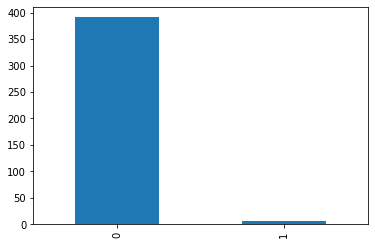

In [11]:
cars['type'] = np.where(cars['car name'].str.contains('diesel'), 1, 0)
cars['type'].value_counts().plot(kind='bar')

In [12]:
cars.pop('car name')

0      chevrolet chevelle malibu
1              buick skylark 320
2             plymouth satellite
3                  amc rebel sst
4                    ford torino
                 ...            
393              ford mustang gl
394                    vw pickup
395                dodge rampage
396                  ford ranger
397                   chevy s-10
Name: car name, Length: 398, dtype: object

In [13]:
print ("Presence of any null values:" + str(cars.isnull().values.any()))

Presence of any null values:False


## EDA

The purpose of EDA is to enhance our understanding of trends in the dataset without involving complicated machine learning models. Oftentimes, we can see obvious traits using graphs and charts just from plotting columns of the dataset against each other.

We’ve completed the necessary preprocessing steps, so let’s create a correlation map to see the relations between different features.

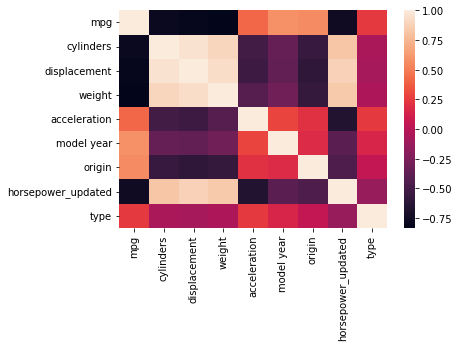

In [14]:
corr = cars.corr()
sns.heatmap(corr)
plt.show()

### Notes:

- There are some strong correlations between each column. For cylinders, displacement, horse-power, and weight, it makes sense that the mpg would be negatively correlated with rising trends in any of the named features.
- Model year and origin also make sense, since non-American/European countries may contain more fuel-efficient standards due to different fuel prices in those areas.

Next, we can plot the number of cars based on their origin (US = 1, Asia = 2, Europe = 3). This is important to us because we’re assuming that different regions have different fuel efficiency priorities, so our model will be skewed towards the region with the most cars in the dataset.

<AxesSubplot:>

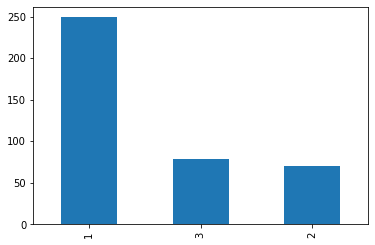

In [15]:
cars['origin'].value_counts().plot(kind='bar')

With 1 corresponding to American cars, we can see that the US accounts for the majority of the cars produced here. **This may be a problem for our model, but if our accuracy is too low, then we can always normalize the presence of each area in the dataset to get predictions that aren’t skewed towards American car mpg**.

We can also view the distributions of different cylinder counts among our dataset.

<AxesSubplot:>

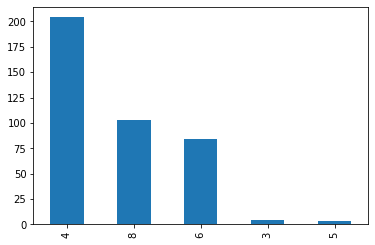

In [16]:
cars['cylinders'].value_counts().plot(kind='bar')

Notice how many cars have 4 cylinders versus 8/6 and 3/5. The V3 is an older engine design that was rarely used in production cars, while the V5 counts can be attributed to Volkswagen’s VR5 engine design.

Since the dataset uses pre-2000s cars, it makes sense how 4 cylinder cars are extremely popular. As time went on, the popularity of the SUV led to more cars having 6–8 cylinders in their engines.

A boxplot will help us better visualize what is happening with the data. Using seaborn’s builtin boxplot method, I’ve made the plot below, which plots car origin against the mpgs of the individual cars:

<AxesSubplot:xlabel='origin', ylabel='mpg'>

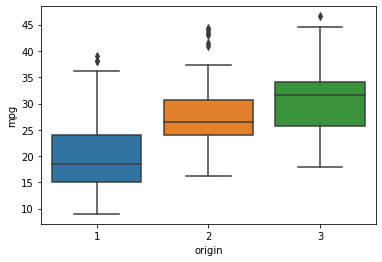

In [20]:
sns.boxplot(x='origin', y='mpg', data=cars)

Before we discuss the box plot, it seems that outliers are affecting our averages, especially for European cars. We can use Python and pandas to see what outliers are present.

<AxesSubplot:xlabel='origin', ylabel='mpg'>

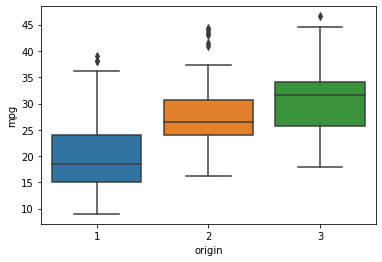

In [22]:
american_cars = cars[cars['origin'] == 1]
japanese_cars = cars[cars['origin'] == 3]
european_cars = cars[cars['origin'] == 2]

quantile_usa = american_cars['mpg'].quantile(0.90)
quantile_jp = japanese_cars['mpg'].quantile(0.90)
quantile_eu = european_cars['mpg'].quantile(0.90)

american_cars[american_cars['mpg'] < quantile_usa] 
european_cars[european_cars['mpg'] < quantile_eu] 
japanese_cars[japanese_cars['mpg'] < quantile_jp]

frames = [american_cars, european_cars, japanese_cars] 
df = pd.concat(frames)

sns.boxplot(x='origin', y='mpg', data=df)

**Note:** USA = 1, Europe = 2, and Asia = 3

From the boxplot, we can see that the Asian cars often have significantly higher mpg than American/European cars. This may be a contributing factor as to why Japanese cars dominated the automotive industry during that time period.

**Note:** We should also expect that our predicted mpg values will oftentimes be lower than the actual number because of the amount of American cars present within our dataset.

We could equalize the distributions of the cars based on region, but doing so would drastically reduce the amount of data points we can use, possibly causing problems in our model due to the lack of training data.

# Model Training

Since there are multiple algorithms we can use to build our model, we will compare the accuracy scores after testing and pick the most accurate algorithm.

In [23]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split


In [24]:
training, test = train_test_split(cars, test_size=0.3, shuffle=True)
training, valid = train_test_split(training, test_size=0.3 ,shuffle=True)
                                   
training_label = training.pop('mpg')
test_label = test.pop('mpg')
valid_label = valid.pop('mpg')

In [25]:
# instantiate training models
xgb = XGBRegressor()
dtc = DecisionTreeRegressor()
rfc = RandomForestRegressor()
knn = KNeighborsRegressor(n_neighbors=3)

# train the models
xgb.fit(training, training_label)
dtc.fit(training, training_label)
rfc.fit(training, training_label)
knn.fit(training, training_label)

KNeighborsRegressor(n_neighbors=3)

# Testing Model

Because we are doing regression testing, we use sklearn’s built-in mean_squared_error() method and then use math.sqrt() to get the RMSE (root mean squared error).

In [27]:
from sklearn.metrics import mean_squared_error
import math

In [26]:
xgb_predict = xgb.predict(test)
dtc_predict = dtc.predict(test)
rfc_predict = rfc.predict(test)
knn_predict = knn.predict(test)

In [28]:
accuracy = dict()

accuracy['XGBoost'] = math.sqrt(mean_squared_error(test_label, xgb_predict)) 
accuracy['DecisionTree'] = math.sqrt(mean_squared_error(test_label, dtc_predict))
accuracy['RandomForest'] = math.sqrt(mean_squared_error(test_label, rfc_predict))
accuracy['KNN'] = math.sqrt(mean_squared_error(test_label,knn_predict))

print(accuracy)

{'XGBoost': 3.109520979207271, 'DecisionTree': 3.8398676192459202, 'RandomForest': 3.1849935701138663, 'KNN': 4.620609026716909}


These results for the testing set match about what others have achieved for this dataset. With some additional fine tuning, we can lower the RMSE even further. Let’s run our validation testing, and see what our RMSE values are.

In [30]:
# perform validation testing for dataset 
xgb_predict = xgb.predict(valid) 
dtc_predict = dtc.predict(valid) 
rfc_predict = rfc.predict(valid) 
knn_predict = knn.predict(valid)

# judge accuracy using built-in function
accuracy['XGBoost'] = math.sqrt(mean_squared_error(valid_label, xgb_predict)) 
accuracy['DecisionTree'] = math.sqrt(mean_squared_error(valid_label, dtc_predict))
accuracy['RandomForest'] = math.sqrt(mean_squared_error(valid_label, rfc_predict))
accuracy['KNN'] = math.sqrt(mean_squared_error(valid_label, knn_predict))

print(accuracy)

{'XGBoost': 3.29686089697177, 'DecisionTree': 4.531910666122434, 'RandomForest': 3.6809795280216213, 'KNN': 4.919071244123417}


It seems that our model may not be overfitting to our dataset, which is good. While validation testing doesn’t completely eliminate the chance of overfitting, it gives us some confidence for when our model handles new data.

In [31]:
results = pd.DataFrame({'label mpg': valid_label,
'prediction': xgb.predict(valid)})
results.head()

,label mpg,prediction
354,34.5,28.547934
257,19.4,22.435398
0,18.0,17.322826
198,33.0,33.003033
128,15.0,17.455112


From the above table, our model is decently accurate at predicting the mpg of a car.

Even though there is some error, generally, it is accurate enough to be reasonable to use for prediction.

Even after normalizing the amount of cars per region, the errors generally do not improve much. One problem is that the data contains incorrect mpg values for some of the cars.

Looking up many of the cars where there are high error rates reveals vastly different mpg ratings than what is listed in our dataset.

Therefore, our model performs very well overall, and big gaps in mpg are usually due to the data itself being incorrect.

,Algorithms,Percentage
0,XGBoost,3.296861
1,DecisionTree,4.531911
2,RandomForest,3.680980
3,KNN,4.919071


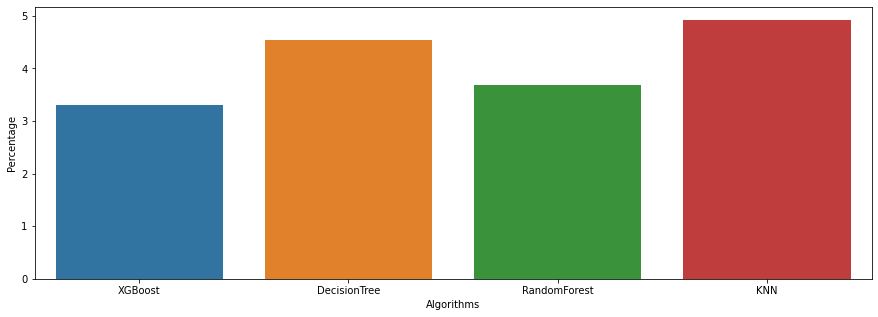

In [32]:
fig, (ax1) = plt.subplots(ncols=1, sharey=True,figsize=(15,5))
new_df=pd.DataFrame(list(accuracy.items()),columns=['Algorithms','Percentage'])
display(new_df)
sns.barplot(x="Algorithms", y="Percentage", data=new_df,ax=ax1);

Again, XGBoost is performing the best, with a RMSE value of 2.5 mpg. While we are picking XGBoost for future predictions, remember that different algorithms tax different resources.

If you are prioritizing training speed and have limited memory and CPU time, XGBoost will probably not be the best choice.

‘Best performing’ is a very deceptive term for machine learning algorithms because performance can be based on a variety of metrics, such as speed, efficiency, or accuracy.

Let’s select the most accurate algorithm (the smallest RMSE value).

In [33]:
max_accuracy = min(accuracy,key=accuracy.get)
max_accuracy

'XGBoost'

The results tell us that our model is decently reliable for the dataset.

Even though some predictions are far away from the actual value, further inspection of the dataset leads me to believe that some of the mpg values are wildly inaccurate.

However, we also don’t have much data to work with, so we chose to keep the incorrect values and replace the outliers with the actual values as we encounter them.

# Conclusion

During this notebook, we built a model that could reliably predict a car’s mpg given some information about the car within 2.5 mpg of the actual value.

This model could be trained with newer car data and be used to predict competitor’s future mpg ratings for upcoming cars, allowing companies to potentially resources currently used on R&D today on making more efficient, more popular vehicles that outshine competitors.

While our model may be inaccurate in some cases, we talked about how our dataset can contain inaccurate values for the mpg, and oftentimes, our predictions are more accurate than the values in the dataset.

For newer cars, the collected data is significantly more reliable, so our model will be able to perform better with a different, more accurate dataset.